In [1]:
#| default_exp basic_plots

In [2]:
#| hide
from nbdev.showdoc import *

In [3]:
#| export

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional
from PIL import Image
from smart_open import open
import warnings

In [4]:
#| export

from pheno_utils.config import (
    ALL_COLOR,
    FEMALE_COLOR, 
    MALE_COLOR, 
    generate_synthetic_data, 
    generate_categorical_synthetic_data
    )

from pheno_utils.bulk_data_loader import load_image

In [30]:
#| export

import pandas as pd

def get_gender_indices(df, gender='male', gender_col='sex'):
    """
    Returns the indices of the requested gender from a specified column in a pandas DataFrame.
    
    Parameters:
    - df: pandas DataFrame.
    - gender: str, 'male' or 'female', the gender to filter by.
    - gender_col: str, the name of the column containing gender information.
    
    Returns:
    - indices: Index object with the indices of the rows matching the requested gender.
    """
    # Normalize gender input to lowercase
    gender = gender.lower()
    
    # Ensure the gender_col exists in the DataFrame
    if gender_col not in df.columns:
        raise ValueError(f"Column '{gender_col}' does not exist in the DataFrame")
    
    # Check the data type of the gender column
    if df[gender_col].dtype == 'int64':
        if gender == 'male':
            indices = df[df[gender_col] == 1].index
        else:
            indices = df[df[gender_col] == 0].index
    elif df[gender_col].dtype.name == 'category':
        categories = df[gender_col].cat.categories
        # Check for string categories "0" and "1"
        if '0' in categories and '1' in categories:
            if gender == 'male':
                indices = df[df[gender_col] == '1'].index
            else:
                indices = df[df[gender_col] == '0'].index
        # Check for string categories "Male" and "Female"
        elif 'Male' in categories or 'male' in categories:
            if gender == 'male':
                indices = df[df[gender_col].isin(['Male', 'male', '1'])].index
            else:
                indices = df[df[gender_col].isin(['Female', 'female', '0'])].index
        else:
            # Assuming numerical categories if none of the above match
            if gender == 'male':
                indices = df[df[gender_col] == 1].index
            else:
                indices = df[df[gender_col] == 0].index
    elif df[gender_col].dtype == 'object' or df[gender_col].dtype.name == 'string':
        if gender == 'male':
            indices = df[df[gender_col].str.lower().isin(['male'])].index
        else:
            indices = df[df[gender_col].str.lower().isin(['female'])].index
    else:
        raise ValueError(f"Unsupported data type for '{gender_col}' column")
    
    return indices

In [31]:
#| export

def data_histplot(data: pd.DataFrame, col: str, feature_str: Optional[str] = None,
                  gender_col: str = "sex", plot_both_genders: bool=True, ax=None) -> None:
    """
    Plots a histogram from a DataFrame for a specific column.

    Args:
        data (pd.DataFrame): The DataFrame containing the data to plot.
        col (str): The name of the column to plot.
        feature_str (Optional[str], optional): The name of the feature to plot. Defaults to None.
        gender_col (str, optional): The name of the column containing gender information. Defaults to "sex".
        plot_both_genders (bool, optional): Whether to plot both genders or just one. Defaults to True.
        ax ([type], optional): The axis to plot on. Defaults to None.
    """
    try:
        assert col in data.columns, f"Column {col} not found in data"
        if plot_both_genders:
            assert gender_col in data.columns, f"Gender column {gender_col} not found in data"
    except AssertionError as e:
        print(e)
        return

    if feature_str is None:
        feature_str = col

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(6, 4))

    # Plot histogram(s)
    if plot_both_genders:
        idx_male = get_gender_indices(data, 'male', gender_col)
        idx_female = get_gender_indices(data, 'female', gender_col)
        sns.histplot(data.loc[idx_female, col], ax=ax, color=FEMALE_COLOR,
                    label=f'females (N={(data.loc[idx_female, col].count()):,})', alpha=0.5)
        sns.histplot(data.loc[idx_male, col], ax=ax, color=MALE_COLOR,
                    label=f'males (N={(data.loc[idx_male, col].count()):,})', alpha=0.5)
        
    else:
        sns.histplot(data.loc[:, col], ax=ax, color=ALL_COLOR,
                    label=f'N={(data.loc[:, col].count()):,}', alpha=0.5)

    ax.set_xlabel(feature_str, fontsize=16)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.legend()

In [32]:
# Generate synthetic data
data = generate_synthetic_data(n=1000)

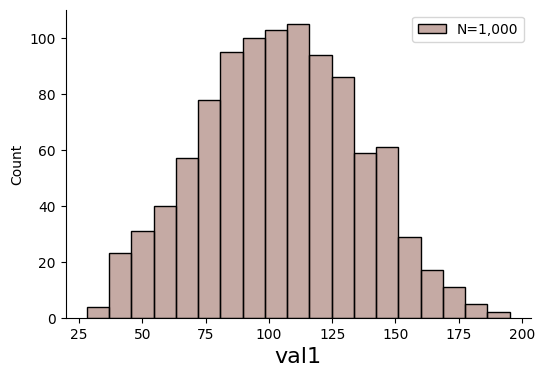

In [33]:
data_histplot(data=data, col="val1", plot_both_genders=False)

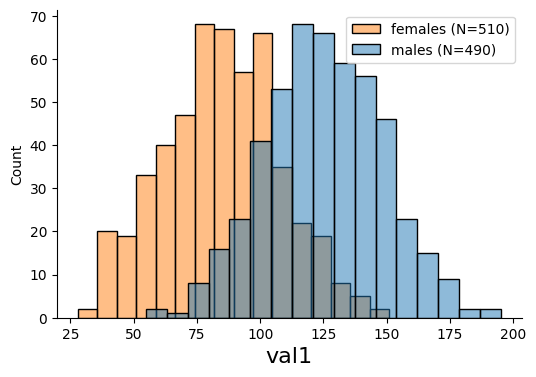

In [34]:
data_histplot(data=data, col="val1")

In [53]:
#| export

def data_ecdfplot(data: pd.DataFrame, col: str, feature_str: Optional[str] = None,
                  gender_col: str = "sex", plot_both_genders: bool=True, ax=None) -> None:
    """
    Plots an empirical cumulative distribution function (ECDF) from a DataFrame for a specific column.

    Args:
        data (pd.DataFrame): The DataFrame containing the data to plot.
        col (str): The name of the column to plot.
        feature_str (Optional[str], optional): The name of the feature to plot. Defaults to None.
        gender_col (str, optional): The name of the column containing gender information. Defaults to "sex".
        plot_both_genders (bool, optional): Whether to plot both genders or just one. Defaults to True.
        ax ([type], optional): The axis to plot on. Defaults to None.
    """
    try:
        assert col in data.columns, f"Column {col} not found in data"
        if plot_both_genders:
            assert gender_col in data.columns, f"Gender column {gender_col} not found in data"
    except AssertionError as e:
        print(e)
        return

    if feature_str is None:
        feature_str = col

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(6, 4))

    # Plot ecdf(s)
    if plot_both_genders:
        idx_male = get_gender_indices(data, 'male', gender_col)
        idx_female = get_gender_indices(data, 'female', gender_col)
        sns.ecdfplot(data.loc[idx_female, col], ax=ax, color=FEMALE_COLOR,
                    label=f'females (N={(data.loc[idx_female, col].count()):,})', alpha=0.5, lw=4)
        sns.ecdfplot(data.loc[idx_male, col], ax=ax, color=MALE_COLOR,
                    label=f'males (N={(data.loc[idx_male, col].count()):,})', alpha=0.5, lw=4)
        
    else:
        sns.ecdfplot(data.loc[:, col], ax=ax, color=ALL_COLOR,
                    label=f'N={(data.loc[:, col].count()):,}', alpha=0.5, lw=4)

    ax.set_xlabel(feature_str, fontsize=16)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.legend()

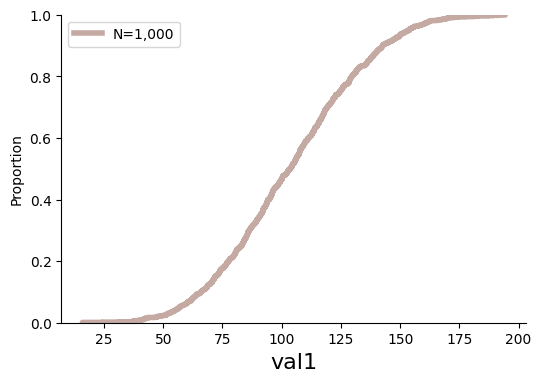

In [54]:
data_ecdfplot(data=data, col="val1", plot_both_genders=False)

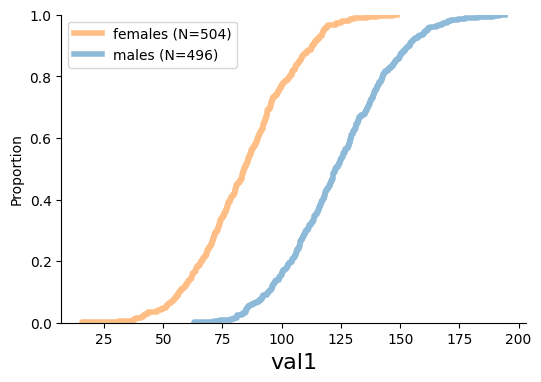

In [55]:
data_ecdfplot(data=data, col="val1")

In [56]:
#| export

def hist_ecdf_plots(data: pd.DataFrame, col: str, feature_str: Optional[str] = None,
                  gender_col: str = "sex", plot_both_genders: bool=True) -> None:
    """
    Plots histograms and empirical cumulative distribution functions (ECDFs) from a DataFrame
    for a specific column.

    Args:
        data: The input DataFrame containing the data to plot.
        col: The column name to plot.
        feature_str: The title of the plot. If not provided, the column name will be used.
        gender_col: The column name indicating sex (default is 'sex' - female:0; male:1).
        plot_both_genders (bool, optional): Whether to plot both genders or just one. Defaults to True.

    Returns:
        None
    """
    try:
        assert col in data.columns, f"Column {col} not found in data"
        if plot_both_genders:
            assert gender_col in data.columns, f"Gender column {gender_col} not found in data"
    except AssertionError as e:
        print(e)
        return

    if feature_str is None:
        feature_str = col

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Plot histograms
    ax = axes[0]
    data_histplot(data=data, col=col, feature_str=feature_str,
                  gender_col=gender_col, plot_both_genders=plot_both_genders, ax=ax)
    # Plot ECDFs
    ax = axes[1]
    data_ecdfplot(data=data, col=col, feature_str=feature_str,
                  gender_col=gender_col, plot_both_genders=plot_both_genders, ax=ax)

    fig.tight_layout()
    plt.show()

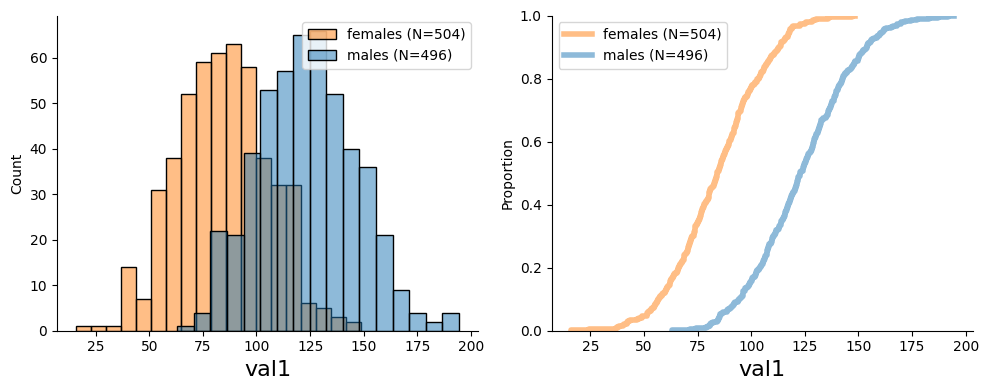

In [57]:
hist_ecdf_plots(data=data, col="val1")

In [58]:
#| export

def plot_stats(data: pd.DataFrame, col: str, ax: plt.Axes, color: str,
               x_position: float = 0.3, label: Optional[str] = "All") -> None:
    """
    Adds a text box to an axis object with summary statistics for a given column in a pandas DataFrame.

    Args:
        data (pd.DataFrame): The pandas DataFrame containing the data to calculate statistics for.
        col (str): The name of the column to calculate statistics for.
        ax (plt.Axes): The axis object to add the text box to.
        color (str): The color of the text box.
        x_position (float, optional): The x position of the text box. Defaults to 0.3.
        label (Optional[str], optional): The label to display in the text box. Defaults to "All".
    """
    # Calculate statistics
    stats = data[col].describe(percentiles=[.10, .90])

    # Rename "50%" to "Median" and "count" to "N"
    stats = stats.rename(index={"50%": "Median", "count": "N"})

    # Ensure "N" is an integer value
    stats["N"] = int(stats["N"])

    # Format statistics for display
    stats_str = f"{label}\n--------------------\n"
    for k, v in stats.items():
        if k == "N":
            stats_str += f"{k}: {int(v)}\n\n"  # Handle "N" separately
        elif np.issubdtype(type(v), np.integer):
            stats_str += f"{k}: {v}\n\n"
        else:
            stats_str += f"{k}: {round(v, 2)}\n\n"

    # Remove trailing newline
    stats_str = stats_str.rstrip("\n")

    # Add textbox to axes
    ax.text(x_position, 0.5, stats_str,
            horizontalalignment='center',
            verticalalignment='center',
            fontsize=9, color='black',
            bbox={'facecolor': color, 'edgecolor': 'black', 'alpha': 0.5, 'pad': 8},
            transform=ax.transAxes)

    # Hide axes
    ax.axis('off')

In [61]:
#| export

def plot_hist_stats(data: pd.DataFrame, col: str, feature_str: Optional[str] = None,
                    gender_col: str = "sex", plot_both_genders: bool=True) -> None:
    """
    Plots a histogram of a given column in a pandas DataFrame and adds summary statistics to the plot.

    Args:
        data (pd.DataFrame): The pandas DataFrame containing the data to plot.
        col (str): The name of the column to plot.
        feature_str (Optional[str], optional): A string describing the feature being plotted. Defaults to None.
        gender_col (str, optional): The name of the column containing gender information. Defaults to "sex".
        plot_both_genders (bool, optional): Whether to plot statistics separately for males and females. Defaults to True.
    """
    # Create a figure and an axes
    fig, axes = plt.subplots(1,2, figsize=(10, 4))

    # Plot histogram on first axis
    ax = axes[0]
    data_histplot(data, col, feature_str, gender_col, plot_both_genders, ax=ax)
    ax.get_legend().remove()  # Remove legend from histogram

    # Plot statistics on second axis
    ax = axes[1]
    if plot_both_genders:
        # Separate data by gender
        idx_male = get_gender_indices(data, 'male', gender_col)
        idx_female = get_gender_indices(data, 'female', gender_col)

        # Plot statistics for males and females separately
        plot_stats(data.loc[idx_male], col, ax=ax, color=MALE_COLOR, x_position=0, label="Males")
        plot_stats(data.loc[idx_female], col, ax=ax, color=FEMALE_COLOR, x_position=0.4, label="Females")

        # Plot statistics for all data
        plot_stats(data.loc[:], col, ax=ax, color=ALL_COLOR, x_position=0.8)

    else:
        # Plot statistics for all data
        plot_stats(data, col, ax=ax, color=ALL_COLOR, x_position=0)

In [62]:
# Generate synthetic data
data = generate_synthetic_data(n=1000)

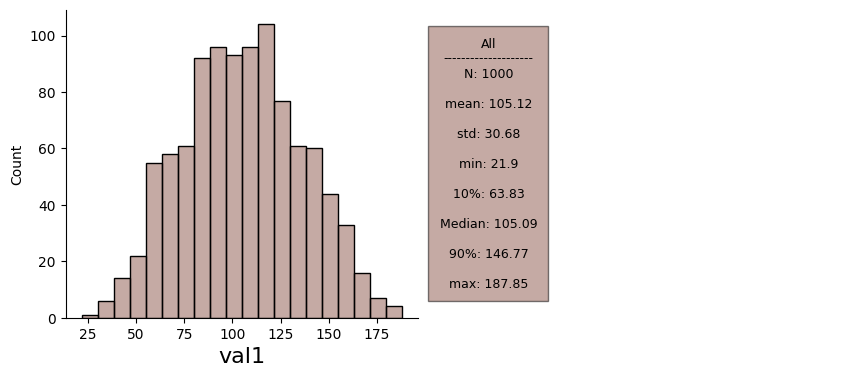

In [63]:
plot_hist_stats(data, "val1", plot_both_genders=False)

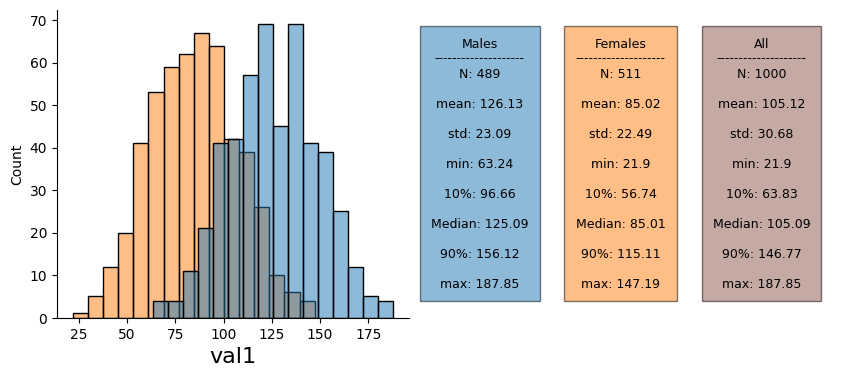

In [64]:
plot_hist_stats(data, "val1")

In [65]:
#| export

def plot_data_collection(data: pd.DataFrame, date_col: str = "collection_date", feature_str: Optional[str] = None, ax: Optional[plt.Axes] = None) -> None:
    """
    Plots a histogram of the specified column in a pandas DataFrame and excludes the last point from the plot.

    Args:
        data (pd.DataFrame): The pandas DataFrame containing the data to plot.
        date_col (str, optional): The name of the column containing the dates. Defaults to "collection_date".
        feature_str (Optional[str], optional): The name of the feature to plot. If None, the name of the date column will be used. Defaults to None.
        ax (Optional[plt.Axes], optional): The axis object to plot on. If None, a new figure and axis will be created. Defaults to None.
    """
    if feature_str is None:
        feature_str = ""

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(6, 3))

    df = data.sort_values(date_col).dropna()

    # Calculate cumulative count of rows
    df['cumulative_count'] = range(1, len(df) + 1)

    # Plot cumulative count over time
    ax.plot(df[date_col], df['cumulative_count'], lw=3, alpha=0.8)

    # Rotate x-axis tick labels by 90 degrees
    plt.xticks(rotation=90)

    # Remove top and right spines
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    ax.set_ylabel(f"{feature_str} data collected", fontsize=14)

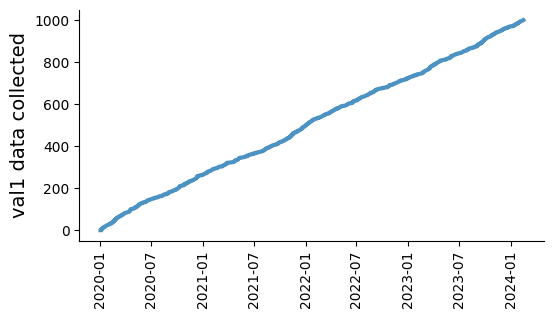

In [66]:
plot_data_collection(data, date_col="date_of_research_stage", feature_str="val1")

In [67]:
#| export

def show_fundus(fname: str) -> None:
    warnings.warn('show_fundus() is deprecated in favour of bulk_data_loader.load_image() and will be removed in a future version.')
    load_image(fname)  

In [68]:
#| export

def plot_horizontal_count_bars(data, column_name, hue=None, n=20):
    """
    Function to plot horizontal bar charts with counts.
    
    Parameters:
    - data (pd.DataFrame): DataFrame containing the data
    - y (str): Column name for the y-axis
    - hue (str, optional): Column name for the hue (default is None)
    - n (int, optional): Number of top categories to display (default is None, showing all)
    
    Returns:
    - ax (Axes object): The plot
    """
    plt.figure(figsize=(10,6))
    
    value_counts = data[column_name].value_counts()
    top_categories = value_counts.index 
    
    
    # Get top n categories based on value counts
    top_categories = top_categories[:n]
    # Filter data to retain only top n categories
    data = data[data[column_name].isin(top_categories)]
    
        
    if hue:
        ax = sns.countplot(data=data, y=column_name, hue=hue, palette='viridis', order=top_categories)
    else: 
        ax = sns.countplot(data=data, y=column_name, color='cornflowerblue', order=top_categories)
    
    if (n < len(top_categories)):
        plt.title(f'Top {n} {column_name.title()} Value Counts')
    else:
        plt.title(f'{column_name.title()} Value Counts')

    # Adding annotations
    for p in ax.patches:
        if p.get_width() == 0 and p.get_height() == 0:
            continue

        factor = 0.03 * p.get_width() 
        ax.annotate(f'{int(p.get_width())}', 
                    (p.get_x() + p.get_width() + factor, p.get_y() + p.get_height()/2),
                    ha='center', va='center')
    


In [69]:
# Generate categorical synthetic data
categorical_data = generate_categorical_synthetic_data(n=1000)

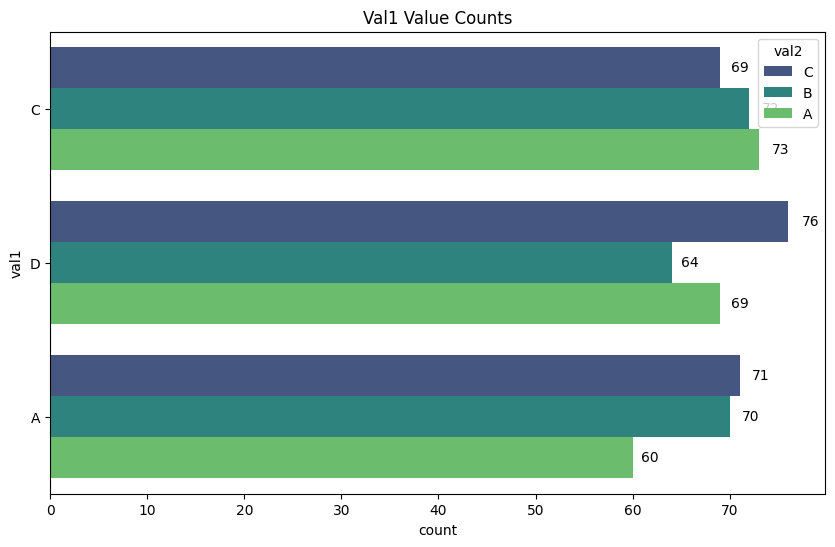

In [70]:
plot_horizontal_count_bars(categorical_data, 'val1', hue='val2', n=3)

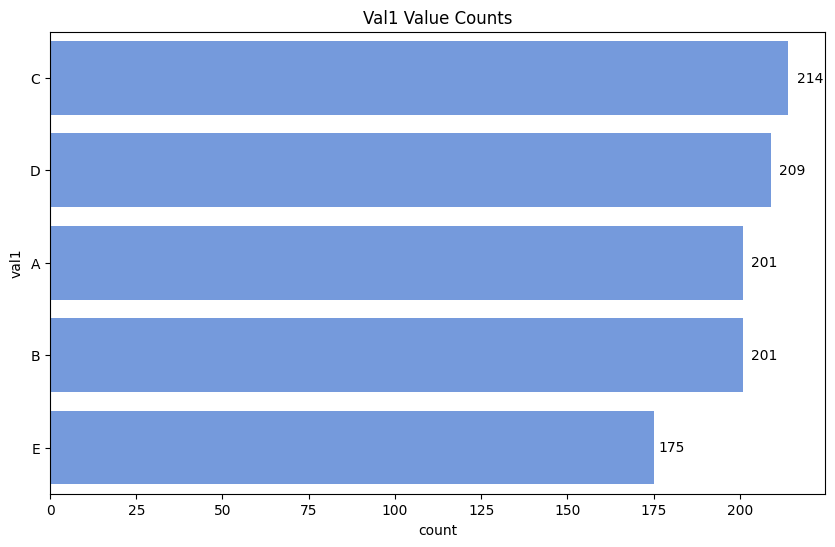

In [71]:
plot_horizontal_count_bars(categorical_data, 'val1', hue=None)

In [72]:
#| hide
import nbdev; nbdev.nbdev_export()